In [2]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def extract_edges(nodes, distance_threshold):
    pairwise_distances = pdist(nodes)
    distance_matrix = squareform(pairwise_distances)
    edges_indices = np.where(distance_matrix < distance_threshold)
    edges = [(i, j) for i, j in zip(edges_indices[0], edges_indices[1]) if i < j]
    return edges

In [4]:
# Load nodes from a Pandas DataFrame
# Example DataFrame with columns X, Y, Z, Atom_Name, Residue_Name, Residue_ID, Atom_Type, and Timeframe
# Load nodes for all timesteps from a .npy file
filepath = '/home/mhanowar/Downloads/dataframe100frames.csv'  # Replace with the actual file path
df = pd.read_csv(filepath)
atom_types = ['o', 'os', 'n', 'hn']
df_nodes = df.query('Atom_Type in @atom_types').reset_index(drop=True)
df_nodes

,X,Y,Z,Atom_Name,Residue_Name,Residue_ID,Atom_Type,Timeframe
0,10.329666,-3.320613,27.787273,O8,CSP,1,os,0
1,8.722559,-3.081730,29.347841,O10,CSP,1,o,0
2,10.848876,-2.234815,29.438032,N11,CSP,1,n,0
3,7.161129,-0.628286,22.912786,O20,CSP,1,os,0
4,6.089050,-0.375813,24.853952,O22,CSP,1,o,0
...,...,...,...,...,...,...,...,...
88395,56.014942,50.285019,44.999348,O2,SFL,12,o,99
88396,64.500870,21.924061,50.197891,O1,SFL,13,os,99
88397,61.827641,20.438919,52.889214,O2,SFL,13,o,99
88398,19.593027,50.211624,47.519764,O1,SFL,14,os,99


In [5]:
# Number of timesteps
# num_timesteps = df_nodes['Timeframe'].nunique()
num_timesteps = 2
# Distance threshold
distance_threshold = 10


In [6]:
# Create an empty list to store DataFrames
edge_info_list = []

# Initialize an empty DataFrame for the final result
columns = ['Edge_idx', 'Atom1_Type', 'Atom2_Type', 'Atom1_Name', 'Atom2_Name',
           'Molecule1', 'Molecule2', 'Edge_Dist', 'Edge_Type', 'Time']
edge_info = pd.DataFrame(columns=columns)

# Iterate over timesteps
for timestep in range(num_timesteps):
    # Get node information for the current timestep
    nodes_info = df_nodes[df_nodes['Timeframe'] == timestep][['Residue_ID',
                                                               'X', 'Y', 'Z', 'Atom_Type', 'Atom_Name']]

    # Get node coordinates, Residue_ID, Atom_Type, and Atom_Name
    nodes = nodes_info[['X', 'Y', 'Z']].values
    residue_ids = nodes_info['Residue_ID'].values
    atom_types = nodes_info['Atom_Type'].values
    atom_names = nodes_info['Atom_Name'].values

    # Extract edges based on the distance threshold
    edges = extract_edges(nodes, distance_threshold)

    # Create a DataFrame for the current timestep
    timestep_df = pd.DataFrame(columns=['Edge_idx', 'Atom1_Type', 'Atom2_Type',
                                        'Atom1_Name', 'Atom2_Name', 'Molecule1', 'Molecule2', 'Edge_Dist', 'Edge_Type', 'Time'])

    # Save edge information to the DataFrame
    for edge_num, edge in enumerate(edges):
        node1 = edge[0]
        node2 = edge[1]
        edge_distance = np.linalg.norm(nodes[node1] - nodes[node2])  # Euclidean distance

        molecule1 = residue_ids[node1]
        molecule2 = residue_ids[node2]

        # Update Edge_Type based on conditions
        if (1 <= molecule1 <= 4 and 5 <= molecule2 <= 14) or (1 <= molecule2 <= 4 and 5 <= molecule1 <= 14):
            edge_type = 0
        elif molecule1 == molecule2:
            edge_type = 1
        else:
            edge_type = 2

        # Save Atom_Type and Atom_Name as Node1 and Node2
        node1_atom_type = atom_types[node1]
        node2_atom_type = atom_types[node2]
        node1_atom_name = atom_names[node1]
        node2_atom_name = atom_names[node2]

        timestep_df = pd.concat([timestep_df, pd.DataFrame({
            'Edge_idx': [edge_num],
            'Atom1_Type': [node1_atom_type],
            'Atom2_Type': [node2_atom_type],
            'Atom1_Name': [node1_atom_name],
            'Atom2_Name': [node2_atom_name],
            'Molecule1': [molecule1],
            'Molecule2': [molecule2],
            'Edge_Dist': [round(edge_distance, 2)],
            'Edge_Type': [edge_type],
            'Time': [timestep]
        })], ignore_index=True)

    print(f'Timestep {timestep}: Number of Edges = {len(edges)}')

    # Append the DataFrame for the current timestep to the list
    edge_info_list.append(timestep_df)

# Concatenate the list of DataFrames into the final DataFrame
edge_info = pd.concat(edge_info_list, ignore_index=True)



/tmp/ipykernel_2622761/3191339415.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  timestep_df = pd.concat([timestep_df, pd.DataFrame({


Timestep 0: Number of Edges = 17622


/tmp/ipykernel_2622761/3191339415.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  timestep_df = pd.concat([timestep_df, pd.DataFrame({


Timestep 1: Number of Edges = 17622


In [7]:
edge_info

,Edge_idx,Atom1_Type,Atom2_Type,Atom1_Name,Atom2_Name,Molecule1,Molecule2,Edge_Dist,Edge_Type,Time
0,0,os,o,O8,O10,1,1,2.25,1,0
1,1,os,n,O8,N11,1,1,2.04,1,0
2,2,os,os,O8,O20,1,1,6.41,1,0
3,3,os,o,O8,O22,1,1,5.94,1,0
4,4,os,n,O8,N23,1,1,7.90,1,0
...,...,...,...,...,...,...,...,...,...,...
35239,17617,os,o,O1,O2,10,10,4.05,1,1
35240,17618,os,o,O1,O2,11,11,4.05,1,1
35241,17619,os,o,O1,O2,12,12,4.00,1,1
35242,17620,os,o,O1,O2,13,13,4.07,1,1


In [8]:
# Print the shape of the DataFrame
print("DataFrame Shape:", edge_info.shape)

filtered_edge_info = edge_info

DataFrame Shape: (35244, 10)


In [10]:
# Merge 'Node1' and 'Molecule1' into 'Node1' with a comma
filtered_edge_info['Node1'] = filtered_edge_info['Atom1_Type'].astype(str) + '_' + filtered_edge_info['Atom1_Name'].astype(str) + '_'+ filtered_edge_info['Molecule1'].astype(str)

# Merge 'Node2' and 'Molecule2' into 'Node2' with a comma
filtered_edge_info['Node2'] = filtered_edge_info['Atom2_Type'].astype(str) + '_' + filtered_edge_info['Atom2_Name'].astype(str) + '_'+ filtered_edge_info['Molecule2'].astype(str)

#filtered_edge_info = filtered_edge_info.drop(['Atom1_Type', 'Atom2_Type','Atom1_Name', 'Atom2_Name', 'Molecule1', 'Molecule2'], axis=1)
# Drop unnecessary columns if needed
filtered_edge_info = filtered_edge_info[['Time', 'Edge_idx', 'Node1', 'Node2', 'Edge_Dist', 'Edge_Type']]
# Print the modified DataFrame
print("Modified DataFrame Shape:", filtered_edge_info.shape)
print(filtered_edge_info)


Modified DataFrame Shape: (35244, 6)
      Time Edge_idx     Node1     Node2  Edge_Dist Edge_Type
0        0        0   os_O8_1   o_O10_1       2.25         1
1        0        1   os_O8_1   n_N11_1       2.04         1
2        0        2   os_O8_1  os_O20_1       6.41         1
3        0        3   os_O8_1   o_O22_1       5.94         1
4        0        4   os_O8_1   n_N23_1       7.90         1
...    ...      ...       ...       ...        ...       ...
35239    1    17617  os_O1_10   o_O2_10       4.05         1
35240    1    17618  os_O1_11   o_O2_11       4.05         1
35241    1    17619  os_O1_12   o_O2_12       4.00         1
35242    1    17620  os_O1_13   o_O2_13       4.07         1
35243    1    17621  os_O1_14   o_O2_14       4.04         1

[35244 rows x 6 columns]


In [11]:
filtered_edge_info.to_csv('filtered_edge_info.csv', index=False)


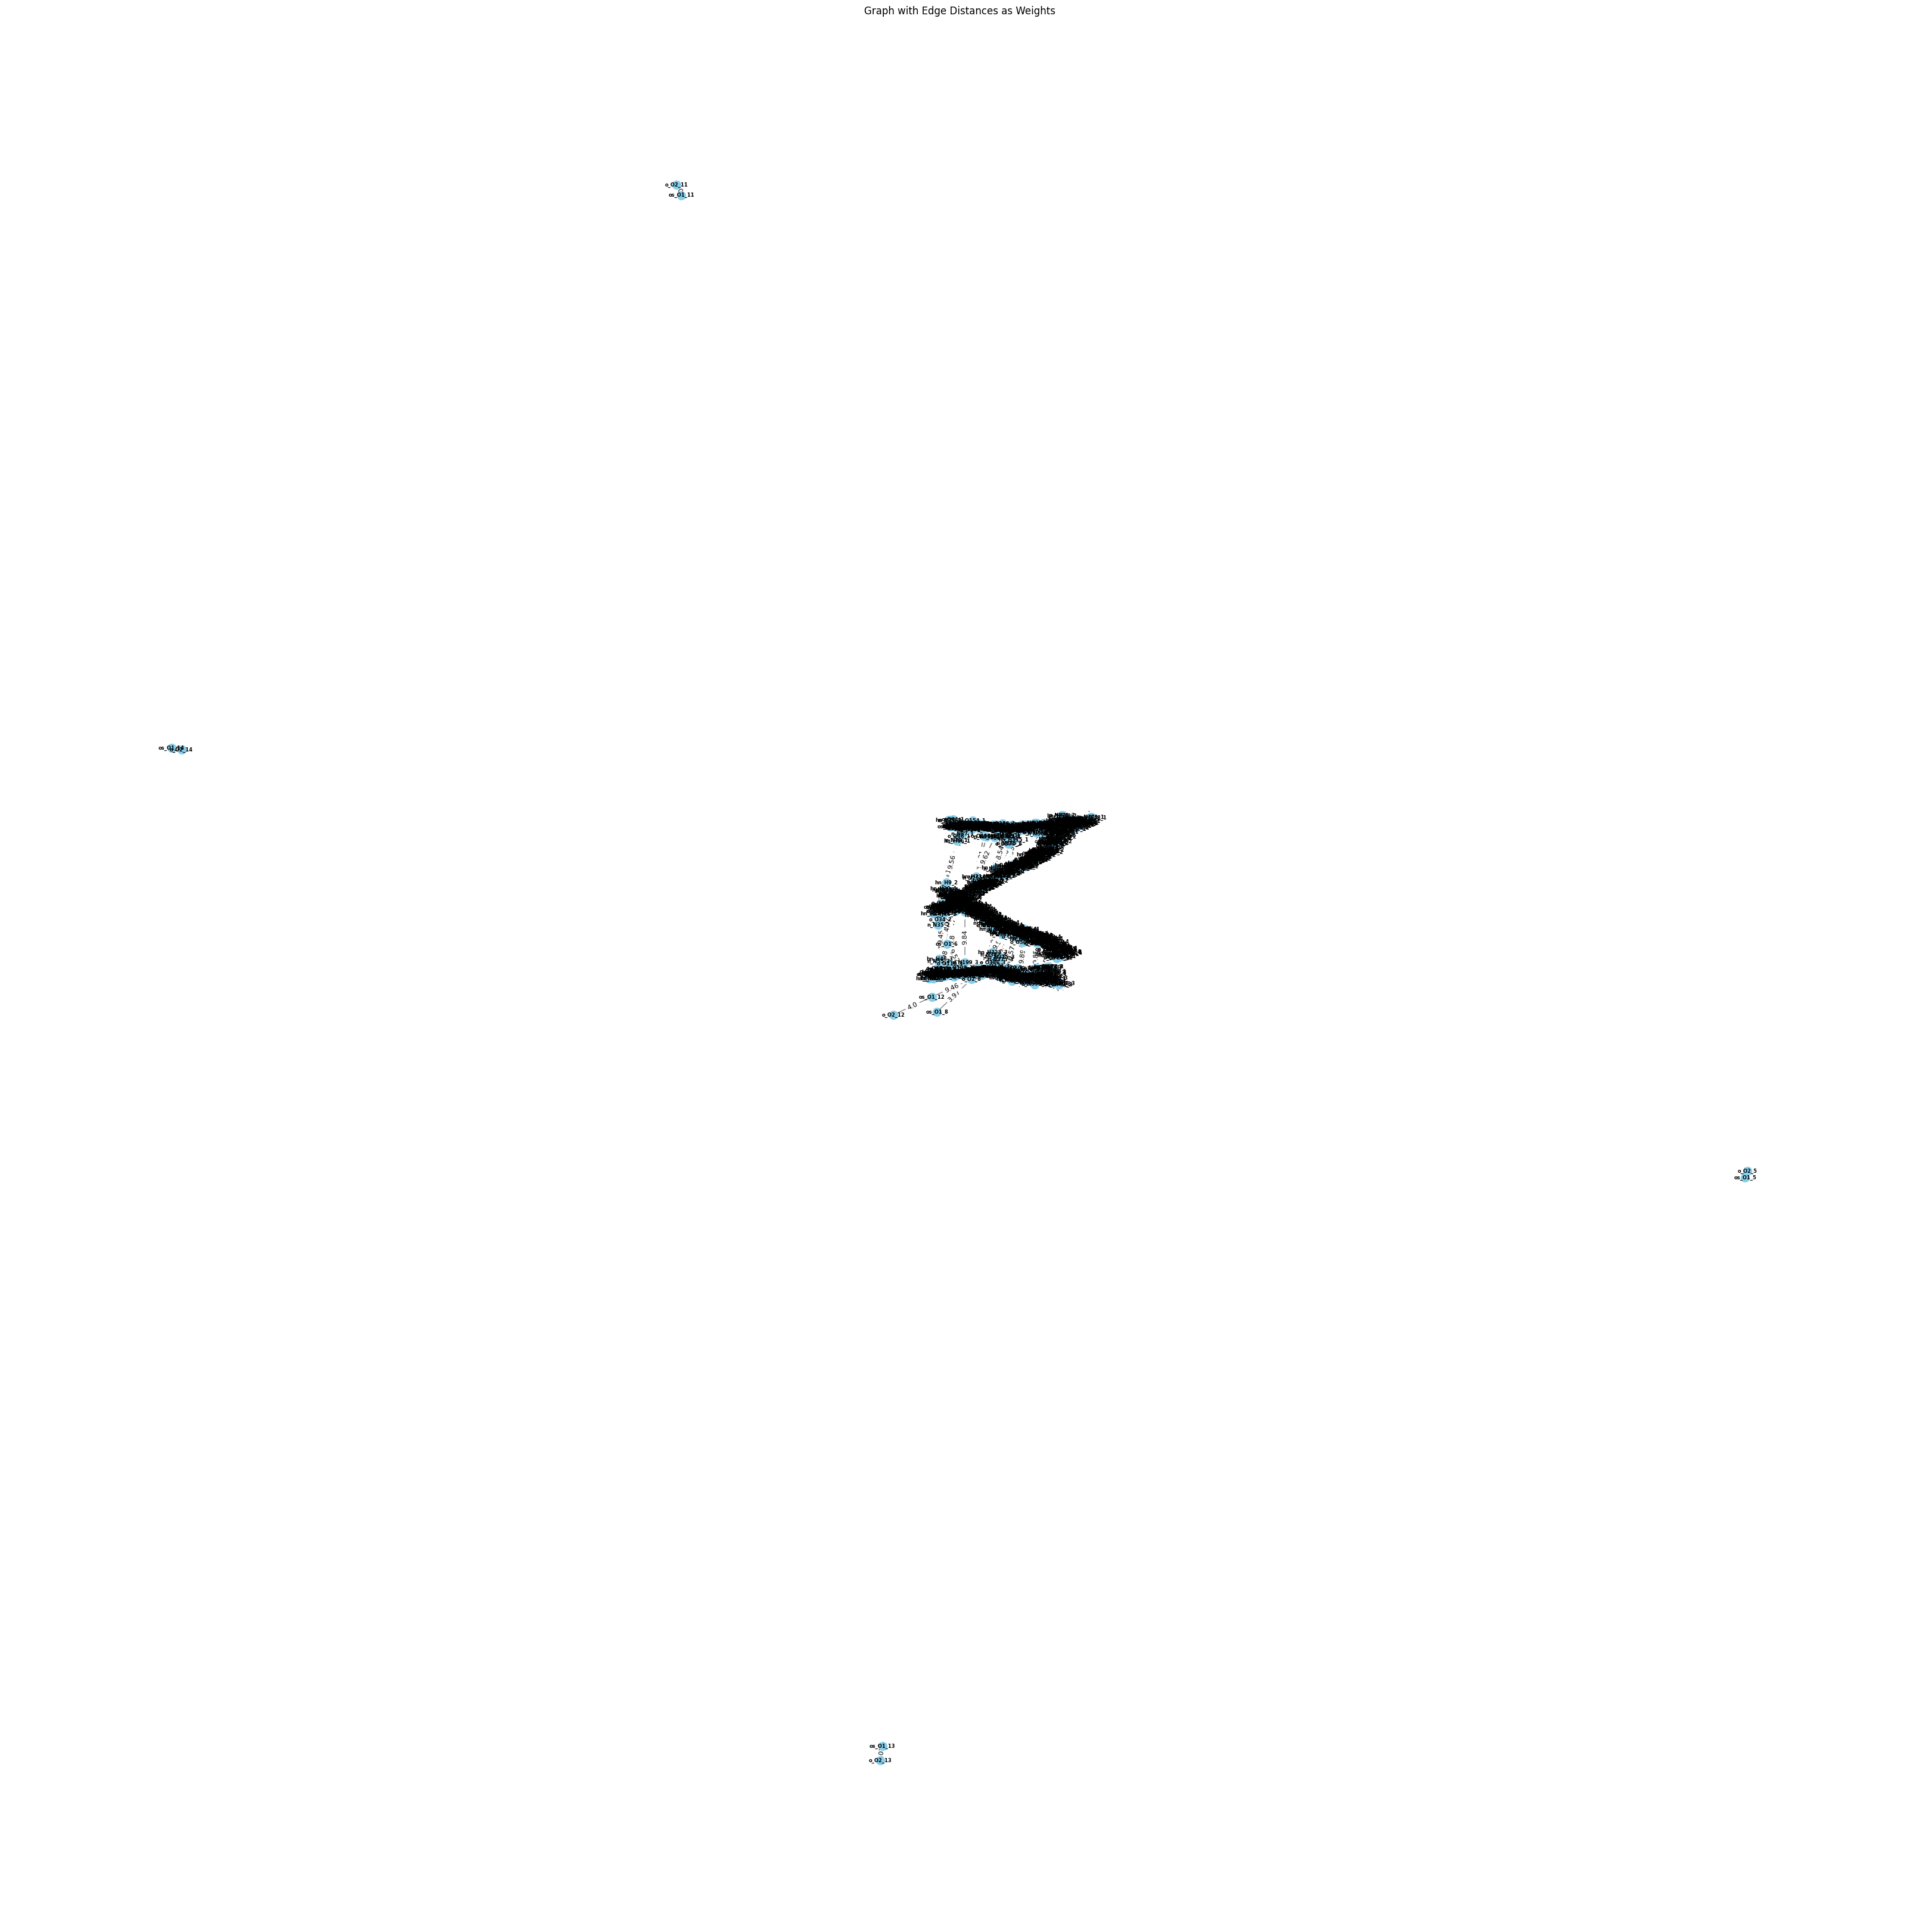

In [12]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

df = filtered_edge_info

# Create a graph
G = nx.Graph()

# Add nodes and edges to the graph
for _, row in df.iterrows():
    G.add_node(row['Node1'])
    G.add_node(row['Node2'])
    G.add_edge(row['Node1'], row['Node2'], weight=row['Edge_Dist'])

# Draw the graph
pos = nx.spring_layout(G)  # You can use different layouts
edge_labels = {(row['Node1'], row['Node2']): round(row['Edge_Dist'], 2) for _, row in df.iterrows()}

plt.figure(figsize=(32,32))
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=100, node_color='skyblue', font_color='black', 
        font_size=6, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title('Graph with Edge Distances as Weights')
plt.show()


In [13]:
import pandas as pd

# Perform one-hot encoding for 'Node1' and 'Node2'
df_encoded = pd.get_dummies(filtered_edge_info, columns=['Node1', 'Node2'], drop_first=True)

# Print the encoded DataFrame
df_encoded


,Time,Edge_idx,Edge_Dist,Edge_Type,Node1_hn_H103_2,Node1_hn_H103_3,Node1_hn_H103_4,Node1_hn_H120_1,Node1_hn_H120_2,Node1_hn_H120_3,...,Node2_os_O76_3,Node2_os_O76_4,Node2_os_O780_1,Node2_os_O780_2,Node2_os_O780_3,Node2_os_O780_4,Node2_os_O96_1,Node2_os_O96_2,Node2_os_O96_3,Node2_os_O96_4
0,0,0,2.25,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,1,2.04,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2,6.41,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,3,5.94,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,4,7.90,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35239,1,17617,4.05,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35240,1,17618,4.05,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35241,1,17619,4.00,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35242,1,17620,4.07,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = filtered_edge_info

# Extract 'Node1' and 'Node2' columns
nodes_data = df[['Node1', 'Node2']]



# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform 'Node1' and 'Node2'
nodes_encoded = encoder.fit_transform(nodes_data)

# Create new column names for the one-hot encoded features
encoded_columns = encoder.get_feature_names_out(['Node1', 'Node2'])

# Replace the original 'Node1' and 'Node2' columns with the one-hot encoded features
df_encoded = pd.concat([df.drop(['Node1', 'Node2'], axis=1), pd.DataFrame(nodes_encoded, columns=encoded_columns)], axis=1)

# Print the encoded DataFrame
df_encoded


/home/mhanowar/Desktop/GNN_repos_server/Virtual_Environment/graphenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Time,Edge_idx,Edge_Dist,Edge_Type,Node1_hn_H103_2,Node1_hn_H103_3,Node1_hn_H103_4,Node1_hn_H120_1,Node1_hn_H120_2,Node1_hn_H120_3,...,Node2_os_O76_3,Node2_os_O76_4,Node2_os_O780_1,Node2_os_O780_2,Node2_os_O780_3,Node2_os_O780_4,Node2_os_O96_1,Node2_os_O96_2,Node2_os_O96_3,Node2_os_O96_4
0,0,0,2.25,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,2.04,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,6.41,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,5.94,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,7.90,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35239,1,17617,4.05,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35240,1,17618,4.05,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35241,1,17619,4.00,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35242,1,17620,4.07,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
import torch

# Assuming 'filtered_edge_info' is a DataFrame with 'Edge_Type' column
edge_type = filtered_edge_info['Edge_Type'].values.astype(int)

# Edge type features using PyTorch
num_edge_types = len(set(edge_type))
print("Number of Edge Types:", num_edge_types)

# One-hot encode the edge types directly using PyTorch
edge_type_feats = torch.nn.functional.one_hot(torch.from_numpy(edge_type), num_classes=num_edge_types)

# Print the one-hot encoded features and their dimensions
print("One-Hot Encoded Features:")
print(edge_type_feats)
print("Feature Dimensions:", edge_type_feats.size(1))


Number of Edge Types: 3
One-Hot Encoded Features:
tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]])
Feature Dimensions: 3


In [ ]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame
# Numeric feature scaling
numeric_features = ['Edge_Dist']
df[numeric_features] = (df[numeric_features] - df[numeric_features].mean()) / df[numeric_features].std()

# Adding random noise to numeric features
numeric_noise = np.random.normal(0, 0.1, size=(len(df), len(numeric_features)))
df[numeric_features] += np.where(df[numeric_features].applymap(np.isreal), numeric_noise, 0)

# Label smoothing for categorical features (assuming 'Node1' and 'Node2' are categorical)
categorical_features = ['Node1', 'Node2']
df[categorical_features] = df[categorical_features].apply(lambda x: x.apply(lambda y: y + np.random.normal(0, 0.1) if isinstance(y, (int, float)) else y))

# Flipping labels for the target variable
df['Edge_Type'] = 1 - df['Edge_Type']

# Adding random noise to the target variable
df['Edge_Type'] += np.random.choice([-1, 0, 1], size=len(df))
df['Edge_Type'] = df['Edge_Type'].clip(0, 1)  # Ensure values are between 0 and 1

# Print the augmented DataFrame
print(df)


      Time Edge_idx     Node1     Node2  Edge_Dist Edge_Type
0        0        0   os_O8_1   o_O10_1  -1.985965         0
1        0        1   os_O8_1   n_N11_1  -2.404371         0
2        0        2   os_O8_1  os_O20_1  -0.262898         1
3        0        3   os_O8_1   o_O22_1  -0.262970         1
4        0        4   os_O8_1   n_N23_1   0.668369         0
...    ...      ...       ...       ...        ...       ...
35239    1    17617  os_O1_10   o_O2_10  -1.356572         0
35240    1    17618  os_O1_11   o_O2_11  -1.283644         0
35241    1    17619  os_O1_12   o_O2_12  -1.425549         0
35242    1    17620  os_O1_13   o_O2_13  -1.340506         0
35243    1    17621  os_O1_14   o_O2_14  -1.303444         0

[35244 rows x 6 columns]


/tmp/ipykernel_2485130/78581602.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_features] = (df[numeric_features] - df[numeric_features].mean()) / df[numeric_features].std()
/tmp/ipykernel_2485130/78581602.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[numeric_features] += np.where(df[numeric_features].applymap(np.isreal), numeric_noise, 0)
/tmp/ipykernel_2485130/78581602.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_features] +